In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Format Output Folder

In [2]:
import os
import shutil

# Specify the directory you want to clean up
output_dir = 'working'

# Loop over all files and directories in the output directory
for filename in os.listdir(output_dir):
    file_path = os.path.join(output_dir, filename)
    
    try:
        # If it is a file or a symbolic link, delete it
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        # If it is a directory, delete it
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

# Dataset Preview

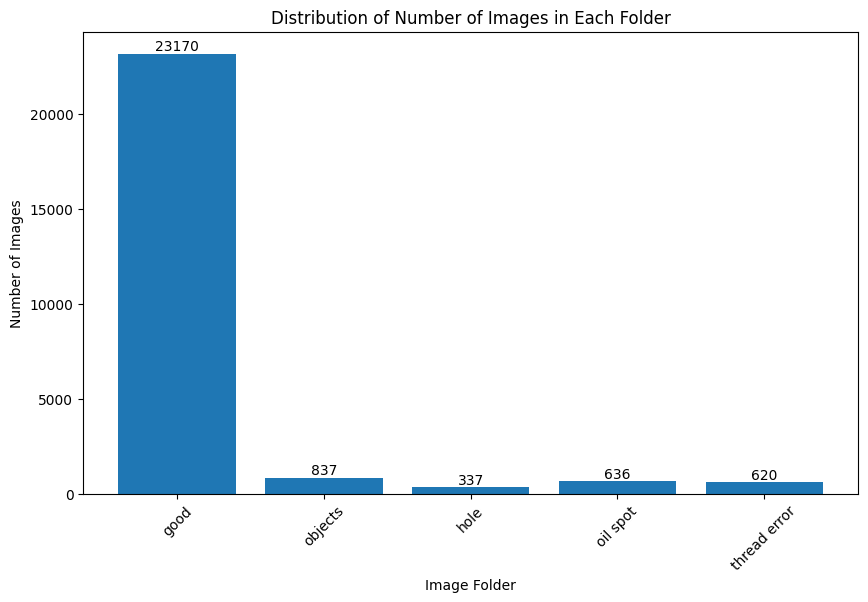

In [3]:
import os
import matplotlib.pyplot as plt

# Define the image folders
image_folders = [
    'tilda/good/',
    'tilda/objects/',
    'tilda/hole/',
    'tilda/oil spot/',
    'tilda/thread error/'
]

# Function to count the number of images in a folder
def count_images_in_folder(folder_path):
    return len([file for file in os.listdir(folder_path) if file.endswith('.png')])

# Get the number of images in each folder
image_counts = [count_images_in_folder(folder) for folder in image_folders]

# Plot the distribution of the number of images inside each folder
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(image_folders)), image_counts)
plt.xticks(range(len(image_folders)), [os.path.basename(folder.rstrip('/')) for folder in image_folders], rotation=45)
plt.xlabel('Image Folder')
plt.ylabel('Number of Images')
plt.title('Distribution of Number of Images in Each Folder')

# Add text labels with the exact number of images above each bar
for bar, count in zip(bars, image_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

plt.show()

# Data Augmentation

In [2]:
import os
import cv2
from PIL import Image
import albumentations as A
import numpy as np
import random

def augment_images(input_folder, output_folder, num_augmentations):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # List all image files in the input folder
    image_files = [filename for filename in os.listdir(input_folder) if filename.endswith('.png')]

    # Randomly select images for augmentation (1000 for the 'good' folder)
    if 'good' in input_folder:
        selected_image_files = random.sample(image_files, min(1000, len(image_files)))
    else:
        selected_image_files = image_files

    # Define the augmentations to apply
    augmentations = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Rotate(limit=180,
                 interpolation=cv2.INTER_LANCZOS4, 
                 border_mode=cv2.BORDER_REFLECT, 
                 p=0.75),
        A.RandomBrightnessContrast(p=0.5),
        A.AdvancedBlur(p=0.33),
        #A.RandomGamma(p=0.25),
        A.RandomBrightnessContrast(p=0.1),
        # A.RandomContrast(p=0.1),
        A.GaussNoise(p=0.25),
        #A.JpegCompression(quality_lower=50, quality_upper=80, p=0.25),
        #A.Sharpen(p=0.1),
        A.UnsharpMask(p=0.1),
        #A.ISONoise(p=0.25),
        #A.PixelDropout(p=0.25)
        #A.Equalize(p=0.25),
        #A.RandomFog(p=0.5),
        #A.RandomSunFlare(p=0.5),
        #A.RandomRain(p=0.5),
        #A.RandomSnow(p=0.5),
    ])

    # Augment and save the new images
    for filename in selected_image_files:
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path)

        for i in range(num_augmentations):
            augmented_image = augmentations(image=np.array(image))['image']
            new_image_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_{i+1}.png")
            Image.fromarray(augmented_image).save(new_image_path)

# Specify input and output folders for image augmentation
input_folders = {
    'tilda/good/': 'working/augmentedData/good/',
    'tilda/objects/': 'working/augmentedData/objects/',
    'tilda/hole/': 'working/augmentedData/hole/',
    'tilda/oil spot/': 'working/augmentedData/oil spot/',
    'tilda/thread error/': 'working/augmentedData/thread error/',
}

# Perform augmentation for each category
num_augmentations = {
    'good': 5,
    'objects': 6,
    'hole': 15,        
    'oil spot': 8,
    'thread error': 8,
}

for input_folder, output_folder in input_folders.items():
    augment_images(input_folder, output_folder, num_augmentations[os.path.basename(os.path.dirname(input_folder))])

# Augmented Data Visualization

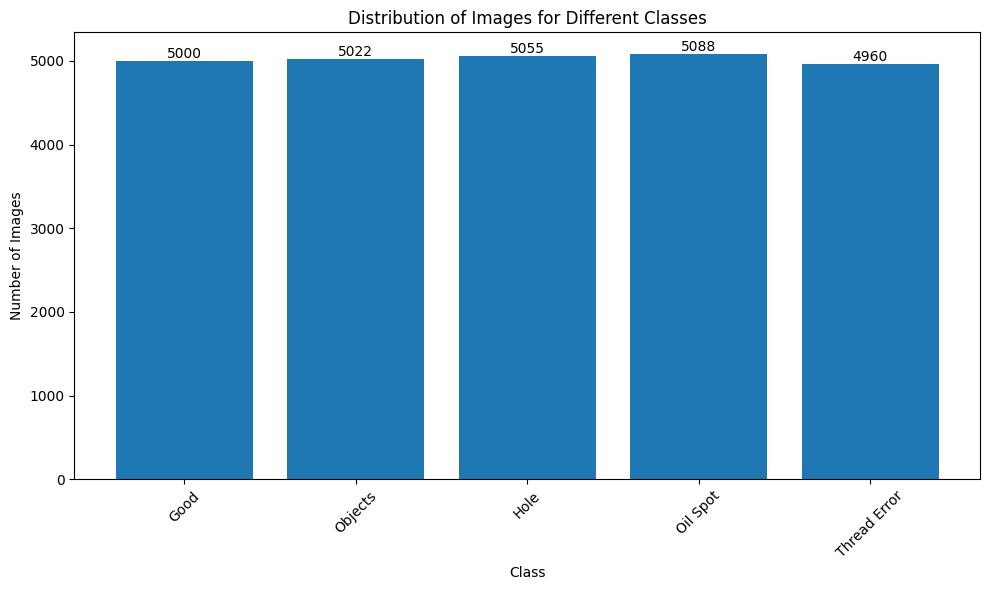

In [5]:
import os
import matplotlib.pyplot as plt

# List of folders for each class
class_folders = ['working/augmentedData/good_augmented/', 
                    'working/augmentedData/objects_augmented/', 
                    'working/augmentedData/hole_augmented/', 
                    'working/augmentedData/oil_spot_augmented/', 
                    'working/augmentedData/thread_error_augmented/']

# Function to count images in a folder
def count_images_in_folder(folder):
    return len([filename for filename in os.listdir(folder) if filename.endswith('.png')])

# Get the number of images in each folder
image_counts = [count_images_in_folder(folder) for folder in class_folders]

# Class labels
class_labels = ['Good', 'Objects', 'Hole', 'Oil Spot', 'Thread Error']

# Plot the distribution of images for each class
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, image_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images for Different Classes')

# Add text labels with the exact number of images above each bar
for bar, count in zip(bars, image_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Multiple CNN Models


## Custom CNN Model

Epoch 1/30
----------


train Progress: 100%|██████████| 367/367 [00:12<00:00, 30.10it/s]


train Loss: 1.7250 Acc: 0.2222


val Progress: 100%|██████████| 367/367 [00:05<00:00, 72.81it/s]


val Loss: 1.9623 Acc: 0.2171
Epoch 2/30
----------


train Progress: 100%|██████████| 367/367 [00:11<00:00, 31.91it/s]


train Loss: 1.6741 Acc: 0.2502


val Progress: 100%|██████████| 367/367 [00:04<00:00, 78.45it/s]


val Loss: 1.7780 Acc: 0.1706
Epoch 3/30
----------


train Progress: 100%|██████████| 367/367 [00:11<00:00, 30.76it/s]


train Loss: 1.6660 Acc: 0.2512


val Progress: 100%|██████████| 367/367 [00:04<00:00, 78.45it/s]


val Loss: 1.6789 Acc: 0.1706
Epoch 4/30
----------


train Progress: 100%|██████████| 367/367 [00:11<00:00, 31.14it/s]


train Loss: 1.6638 Acc: 0.2604


val Progress: 100%|██████████| 367/367 [00:04<00:00, 78.23it/s]


val Loss: 1.6870 Acc: 0.2171
Epoch 5/30
----------


train Progress: 100%|██████████| 367/367 [00:11<00:00, 31.51it/s]


train Loss: 1.6577 Acc: 0.2625


val Progress: 100%|██████████| 367/367 [00:04<00:00, 76.95it/s]


val Loss: 1.7402 Acc: 0.2171
Epoch 6/30
----------


train Progress: 100%|██████████| 367/367 [00:11<00:00, 31.54it/s]


train Loss: 1.6577 Acc: 0.2577


val Progress: 100%|██████████| 367/367 [00:04<00:00, 77.38it/s]


val Loss: 1.7102 Acc: 0.1706
Epoch 7/30
----------


train Progress: 100%|██████████| 367/367 [00:12<00:00, 29.24it/s]


train Loss: 1.6500 Acc: 0.2655


val Progress: 100%|██████████| 367/367 [00:04<00:00, 73.83it/s]


val Loss: 1.7529 Acc: 0.2171
Epoch 8/30
----------


train Progress: 100%|██████████| 367/367 [00:12<00:00, 29.74it/s]


train Loss: 1.6597 Acc: 0.2608


val Progress: 100%|██████████| 367/367 [00:04<00:00, 78.27it/s]


val Loss: 1.6704 Acc: 0.2171
Epoch 9/30
----------


train Progress: 100%|██████████| 367/367 [00:11<00:00, 31.07it/s]


train Loss: 1.6464 Acc: 0.2683


val Progress: 100%|██████████| 367/367 [00:04<00:00, 76.35it/s]


val Loss: 1.6498 Acc: 0.2171
Epoch 10/30
----------


train Progress: 100%|██████████| 367/367 [00:12<00:00, 29.72it/s]


train Loss: 1.6535 Acc: 0.2468


val Progress: 100%|██████████| 367/367 [00:04<00:00, 75.91it/s]


val Loss: 1.6565 Acc: 0.2171
Epoch 11/30
----------


train Progress: 100%|██████████| 367/367 [00:11<00:00, 31.32it/s]


train Loss: 1.6494 Acc: 0.2601


val Progress: 100%|██████████| 367/367 [00:04<00:00, 77.90it/s]


val Loss: 1.6966 Acc: 0.2171
Epoch 12/30
----------


train Progress: 100%|██████████| 367/367 [00:11<00:00, 30.80it/s]


train Loss: 1.6501 Acc: 0.2727


val Progress: 100%|██████████| 367/367 [00:04<00:00, 84.40it/s]


val Loss: 1.6824 Acc: 0.2171
Epoch 13/30
----------


train Progress: 100%|██████████| 367/367 [00:11<00:00, 32.27it/s]


train Loss: 1.6377 Acc: 0.2706


val Progress: 100%|██████████| 367/367 [00:04<00:00, 83.68it/s]


val Loss: 1.6513 Acc: 0.2171
Epoch 14/30
----------


train Progress: 100%|██████████| 367/367 [00:11<00:00, 32.15it/s]


train Loss: 1.6389 Acc: 0.2696


val Progress: 100%|██████████| 367/367 [00:04<00:00, 81.77it/s]


val Loss: 1.6901 Acc: 0.2171
Epoch 15/30
----------


train Progress: 100%|██████████| 367/367 [00:11<00:00, 32.40it/s]


train Loss: 1.6573 Acc: 0.2488


val Progress: 100%|██████████| 367/367 [00:04<00:00, 80.75it/s]


val Loss: 1.6721 Acc: 0.2171
Epoch 16/30
----------


train Progress: 100%|██████████| 367/367 [00:12<00:00, 28.56it/s]


train Loss: 1.6377 Acc: 0.2706


val Progress: 100%|██████████| 367/367 [00:05<00:00, 70.03it/s]


val Loss: 1.6283 Acc: 0.2171
Epoch 17/30
----------


train Progress: 100%|██████████| 367/367 [00:14<00:00, 26.20it/s]


train Loss: 1.6374 Acc: 0.2703


val Progress: 100%|██████████| 367/367 [00:06<00:00, 58.48it/s]


val Loss: 1.6799 Acc: 0.2171
Epoch 18/30
----------


train Progress: 100%|██████████| 367/367 [00:13<00:00, 26.51it/s]


train Loss: 1.6365 Acc: 0.2645


val Progress: 100%|██████████| 367/367 [00:06<00:00, 58.19it/s]


val Loss: 1.6389 Acc: 0.2171
Epoch 19/30
----------


train Progress: 100%|██████████| 367/367 [00:12<00:00, 28.77it/s]


train Loss: 1.6263 Acc: 0.2683


val Progress: 100%|██████████| 367/367 [00:05<00:00, 66.43it/s]


val Loss: 1.6676 Acc: 0.2171
Epoch 20/30
----------


train Progress: 100%|██████████| 367/367 [00:12<00:00, 28.44it/s]


train Loss: 1.6229 Acc: 0.2672


val Progress: 100%|██████████| 367/367 [00:05<00:00, 62.58it/s]


val Loss: 1.6942 Acc: 0.1706
Epoch 21/30
----------


train Progress: 100%|██████████| 367/367 [00:12<00:00, 28.58it/s]


train Loss: 1.6239 Acc: 0.2703


val Progress: 100%|██████████| 367/367 [00:05<00:00, 63.31it/s]


val Loss: 1.6081 Acc: 0.2171
Epoch 22/30
----------


train Progress: 100%|██████████| 367/367 [00:12<00:00, 29.21it/s]


train Loss: 1.6294 Acc: 0.2635


val Progress: 100%|██████████| 367/367 [00:05<00:00, 66.19it/s]


val Loss: 1.6274 Acc: 0.2171
Epoch 23/30
----------


train Progress: 100%|██████████| 367/367 [00:12<00:00, 29.41it/s]


train Loss: 1.6144 Acc: 0.2799


val Progress: 100%|██████████| 367/367 [00:05<00:00, 65.84it/s]


val Loss: 1.6323 Acc: 0.2171
Epoch 24/30
----------


train Progress: 100%|██████████| 367/367 [00:12<00:00, 29.23it/s]


train Loss: 1.6198 Acc: 0.2638


val Progress: 100%|██████████| 367/367 [00:05<00:00, 65.36it/s]


val Loss: 1.6152 Acc: 0.2171
Epoch 25/30
----------


train Progress: 100%|██████████| 367/367 [00:12<00:00, 28.69it/s]


train Loss: 1.6231 Acc: 0.2727


val Progress: 100%|██████████| 367/367 [00:05<00:00, 70.92it/s]


val Loss: 1.6003 Acc: 0.2225
Epoch 26/30
----------


train Progress: 100%|██████████| 367/367 [00:14<00:00, 25.42it/s]


train Loss: 1.6121 Acc: 0.2737


val Progress: 100%|██████████| 367/367 [00:05<00:00, 72.60it/s]


val Loss: 1.6217 Acc: 0.2171
Epoch 27/30
----------


train Progress: 100%|██████████| 367/367 [00:13<00:00, 27.41it/s]


train Loss: 1.6321 Acc: 0.2648


val Progress: 100%|██████████| 367/367 [00:06<00:00, 59.64it/s]


val Loss: 1.6332 Acc: 0.2171
Epoch 28/30
----------


train Progress: 100%|██████████| 367/367 [00:12<00:00, 29.12it/s]


train Loss: 1.6292 Acc: 0.2775


val Progress: 100%|██████████| 367/367 [00:07<00:00, 48.01it/s]


val Loss: 1.6764 Acc: 0.2113
Epoch 29/30
----------


train Progress: 100%|██████████| 367/367 [00:12<00:00, 28.81it/s]


train Loss: 1.6190 Acc: 0.2727


val Progress: 100%|██████████| 367/367 [00:05<00:00, 65.01it/s]


val Loss: 1.6416 Acc: 0.2174
Epoch 30/30
----------


train Progress: 100%|██████████| 367/367 [00:15<00:00, 23.60it/s]


train Loss: 1.6433 Acc: 0.2628


val Progress: 100%|██████████| 367/367 [00:06<00:00, 57.51it/s]


val Loss: 1.6304 Acc: 0.2171
Best val Acc: 0.222526
Validation Loss: 1.6304 Acc: 0.2171
              precision    recall  f1-score   support

        good       0.00      0.00      0.00       500
        hole       0.00      0.00      0.00       337
     objects       0.00      0.00      0.00       837
    oil spot       0.22      1.00      0.36       636
thread error       0.00      0.00      0.00       620

    accuracy                           0.22      2930
   macro avg       0.04      0.20      0.07      2930
weighted avg       0.05      0.22      0.08      2930



/home/sushil/miniconda3/envs/modelPytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sushil/miniconda3/envs/modelPytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sushil/miniconda3/envs/modelPytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

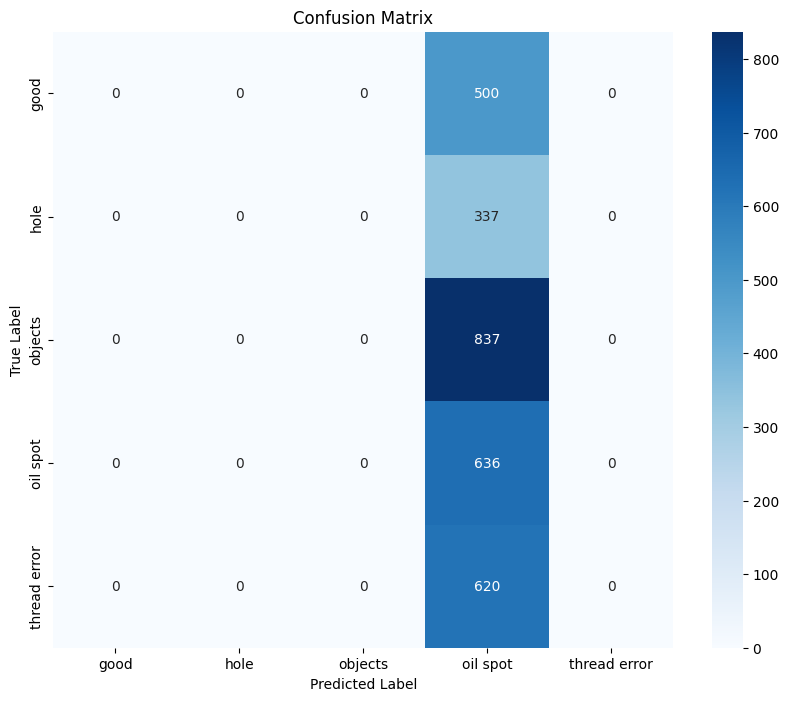

/home/sushil/miniconda3/envs/modelPytorch/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/sushil/miniconda3/envs/modelPytorch/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


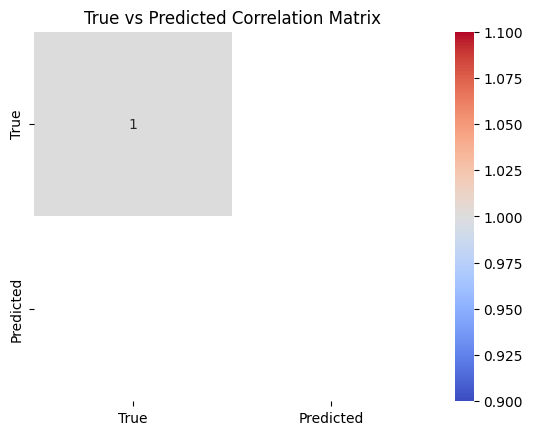

: 

In [9]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from PIL import Image, ImageEnhance
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Grayscale and enhancement parameters
brightness_factor = 1.2
sharpness_factor = 2.0

# Hyperparameters to try
learning_rate = 0.00001
dropout_rates = (0.5, 0.6)
batch_size = 8
epochs = 30
rotation_range = 50
width_shift_range = 0.3
height_shift_range = 0.3
shear_range = 0.3
zoom_range = 0.3

# Preprocessing function to convert image to grayscale, adjust brightness and sharpness
def preprocess_image(image):
    image = array_to_img(image)  # Convert array to PIL Image
    gray_image = image.convert('L')  # Convert to grayscale
    enhancer = ImageEnhance.Brightness(gray_image)
    gray_image_enhanced = enhancer.enhance(brightness_factor)
    enhancer = ImageEnhance.Sharpness(gray_image_enhanced)
    gray_image_sharpened = enhancer.enhance(sharpness_factor)
    return img_to_array(gray_image_sharpened)  # Convert back to array

# Set image size
IMAGE_SIZE = (224, 224)

# Path to your augmented dataset
augmented_dir = 'working/augmentedData'

# Temporary directory for modified dataset
temp_dir = 'temp_dataset/'

# Ensure the temporary directory is clean
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
os.makedirs(temp_dir)

# Function to prepare the dataset
def prepare_dataset(src_dir, dest_dir, selected_class='good', num_samples=500):
    class_dirs = os.listdir(src_dir)
    for class_dir in class_dirs:
        class_path = os.path.join(src_dir, class_dir)
        dest_class_path = os.path.join(dest_dir, class_dir)
        os.makedirs(dest_class_path, exist_ok=True)
        
        if class_dir == selected_class:
            images = os.listdir(class_path)
            selected_images = random.sample(images, num_samples)
            for image in selected_images:
                shutil.copy(os.path.join(class_path, image), dest_class_path)
        else:
            for image in os.listdir(class_path):
                shutil.copy(os.path.join(class_path, image), dest_class_path)

# Prepare the dataset
prepare_dataset(augmented_dir, temp_dir, selected_class='good', num_samples=500)

# Data generator for loading and augmenting images with preprocessing function
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=True,
    fill_mode='constant', cval=0,
    validation_split=0.3,  # Use 30% of the data for validation
    preprocessing_function=preprocess_image
)

# Data generators
train_generator = datagen.flow_from_directory(
    temp_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Ensure that the data generator knows we are working with grayscale images
)

validation_generator = datagen.flow_from_directory(
    temp_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Ensure that the data generator knows we are working with grayscale images
)

# Define the custom CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rates[0]),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rates[0]),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rates[1]),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rates[1]),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rates[1]),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
model.save('custom_cnn_model.h5')

# Print training history
print(history.history)

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Generate predictions for the validation set
val_steps = validation_generator.samples // validation_generator.batch_size
validation_generator.reset()
predictions = model.predict(validation_generator, steps=val_steps, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes[:len(predicted_classes)]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=validation_generator.class_indices.keys()))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(true_classes, predicted_classes)

# Display the correlation matrix
correlation_df = pd.DataFrame(correlation_matrix, index=['True', 'Predicted'], columns=['True', 'Predicted'])
sns.heatmap(correlation_df, annot=True, cmap='coolwarm')
plt.title('True vs Predicted Correlation Matrix')
plt.show()

## Combined EfficientNetB0 and InceptionV3

In [ ]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from PIL import Image, ImageEnhance, ImageFilter
from tensorflow.keras.applications import EfficientNetB0, InceptionV3
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Grayscale and enhancement parameters
brightness_factor = 1.2
sharpness_factor = 2.0

# Hyperparameters to try
learning_rate = 0.00001
dropout_rates = (0.5, 0.6)
batch_size = 8
epochs = 30
rotation_range = 50
width_shift_range = 0.3
height_shift_range = 0.3
shear_range = 0.3
zoom_range = 0.3

# Preprocessing function to convert image to grayscale, adjust brightness and sharpness
def preprocess_image(image):
    image = array_to_img(image)  # Convert array to PIL Image
    gray_image = image.convert('L')  # Convert to grayscale
    enhancer = ImageEnhance.Brightness(gray_image)
    gray_image_enhanced = enhancer.enhance(brightness_factor)
    enhancer = ImageEnhance.Sharpness(gray_image_enhanced)
    gray_image_sharpened = enhancer.enhance(sharpness_factor)
    return img_to_array(gray_image_sharpened)  # Convert back to array

# Set image size for both models
IMAGE_SIZE = (224, 224)

# Path to your augmented dataset
augmented_dir = 'working/augmentedData'

# Temporary directory for modified dataset
temp_dir = 'temp_dataset/'

# Ensure the temporary directory is clean
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
os.makedirs(temp_dir)

# Function to prepare the dataset
def prepare_dataset(src_dir, dest_dir, selected_class='good', num_samples=500):
    class_dirs = os.listdir(src_dir)
    for class_dir in class_dirs:
        class_path = os.path.join(src_dir, class_dir)
        dest_class_path = os.path.join(dest_dir, class_dir)
        os.makedirs(dest_class_path, exist_ok=True)
        
        if class_dir == selected_class:
            images = os.listdir(class_path)
            selected_images = random.sample(images, num_samples)
            for image in selected_images:
                shutil.copy(os.path.join(class_path, image), dest_class_path)
        else:
            for image in os.listdir(class_path):
                shutil.copy(os.path.join(class_path, image), dest_class_path)

# Prepare the dataset
prepare_dataset(augmented_dir, temp_dir, selected_class='good', num_samples=500)

# Data generator for loading and augmenting images with preprocessing function
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=True,
    fill_mode='constant', cval=0,
    validation_split=0.3,  # Use 30% of the data for validation
    preprocessing_function=preprocess_image
)

# Data generators
train_generator = datagen.flow_from_directory(
    temp_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Ensure that the data generator knows we are working with grayscale images
)

validation_generator = datagen.flow_from_directory(
    temp_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Ensure that the data generator knows we are working with grayscale images
)

# Define the inputs
input_shape = (224, 224, 1)  # Update input shape to reflect grayscale images
input_tensor = Input(shape=input_shape)

# Define EfficientNetB0 model
efficientnet_base = EfficientNetB0(weights=None, include_top=False, input_tensor=input_tensor)
efficientnet_output = GlobalAveragePooling2D()(efficientnet_base.output)

# Define InceptionV3 model
inception_base = InceptionV3(weights=None, include_top=False, input_tensor=input_tensor)
inception_output = GlobalAveragePooling2D()(inception_base.output)

# Combine the outputs of EfficientNetB0 and InceptionV3
combined = concatenate([efficientnet_output, inception_output])

# Add final fully connected layers with dropout and batch normalization for regularization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(combined)
x = BatchNormalization()(x)
x = Dropout(dropout_rates[0])(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rates[1])(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=input_tensor, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
model.save('combined_efficientnet_inception_model.h5')

# Print training history
print(history.history)

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Generate predictions for the validation set
val_steps = validation_generator.samples // validation_generator.batch_size
validation_generator.reset()
predictions = model.predict(validation_generator, steps=val_steps, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes[:len(predicted_classes)]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=validation_generator.class_indices.keys()))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(true_classes, predicted_classes)

# Display the correlation matrix
correlation_df = pd.DataFrame(correlation_matrix, index=['True', 'Predicted'], columns=['True', 'Predicted'])
sns.heatmap(correlation_df, annot=True, cmap='coolwarm')
plt.title('True vs Predicted Correlation Matrix')
plt.show()

In [ ]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from PIL import Image, ImageEnhance, ImageFilter
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Grayscale and enhancement parameters
brightness_factor = 1.2
sharpness_factor = 2.0

# Hyperparameters to try
learning_rate = 0.00001
dropout_rates = (0.5, 0.6)
batch_size = 8
epochs = 30
rotation_range = 50
width_shift_range = 0.3
height_shift_range = 0.3
shear_range = 0.3
zoom_range = 0.3

# Preprocessing function to convert image to grayscale, adjust brightness and sharpness
def preprocess_image(image):
    image = array_to_img(image)  # Convert array to PIL Image
    gray_image = image.convert('L')  # Convert to grayscale
    enhancer = ImageEnhance.Brightness(gray_image)
    gray_image_enhanced = enhancer.enhance(brightness_factor)
    enhancer = ImageEnhance.Sharpness(gray_image_enhanced)
    gray_image_sharpened = enhancer.enhance(sharpness_factor)
    return img_to_array(gray_image_sharpened)  # Convert back to array

# Set image size for the model
IMAGE_SIZE = (224, 224)

# Path to your augmented dataset
augmented_dir = 'working/augmentedData'

# Temporary directory for modified dataset
temp_dir = 'temp_dataset/'

# Ensure the temporary directory is clean
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
os.makedirs(temp_dir)

# Function to prepare the dataset
def prepare_dataset(src_dir, dest_dir, selected_class='good', num_samples=500):
    class_dirs = os.listdir(src_dir)
    for class_dir in class_dirs:
        class_path = os.path.join(src_dir, class_dir)
        dest_class_path = os.path.join(dest_dir, class_dir)
        os.makedirs(dest_class_path, exist_ok=True)
        
        if class_dir == selected_class:
            images = os.listdir(class_path)
            selected_images = random.sample(images, num_samples)
            for image in selected_images:
                shutil.copy(os.path.join(class_path, image), dest_class_path)
        else:
            for image in os.listdir(class_path):
                shutil.copy(os.path.join(class_path, image), dest_class_path)

# Prepare the dataset
prepare_dataset(augmented_dir, temp_dir, selected_class='good', num_samples=500)

# Data generator for loading and augmenting images with preprocessing function
datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=rotation_range,
#     width_shift_range=width_shift_range,
#     height_shift_range=height_shift_range,
#     shear_range=shear_range,
#     zoom_range=zoom_range,
#     horizontal_flip=True,
#     fill_mode='constant', cval=0,
    validation_split=0.3,  # Use 30% of the data for validation
    preprocessing_function=preprocess_image
)

# Data generators
train_generator = datagen.flow_from_directory(
    temp_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Ensure that the data generator knows we are working with grayscale images
)

validation_generator = datagen.flow_from_directory(
    temp_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Ensure that the data generator knows we are working with grayscale images
)

# Define the inputs
input_shape = (224, 224, 1)  # Update input shape to reflect grayscale images
input_tensor = Input(shape=input_shape)

# Define InceptionV3 model
inception_base = InceptionV3(weights=None, include_top=False, input_tensor=input_tensor)
inception_output = GlobalAveragePooling2D()(inception_base.output)

# Add additional fully connected layers with dropout and batch normalization for regularization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(inception_output)
x = BatchNormalization()(x)
x = Dropout(dropout_rates[0])(x)

x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rates[1])(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=input_tensor, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
model.save('inception_model.h5')

# Print training history
print(history.history)

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Generate predictions for the validation set
val_steps = validation_generator.samples // validation_generator.batch_size
validation_generator.reset()
predictions = model.predict(validation_generator, steps=val_steps, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes[:len(predicted_classes)]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=validation_generator.class_indices.keys()))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(true_classes, predicted_classes)

# Display the correlation matrix
correlation_df = pd.DataFrame(correlation_matrix, index=['True', 'Predicted'], columns=['True', 'Predicted'])
sns.heatmap(correlation_df, annot=True, cmap='coolwarm')
plt.title('True vs Predicted Correlation Matrix')
plt.show()

In [ ]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from PIL import Image, ImageEnhance, ImageFilter
from tensorflow.keras.applications import EfficientNetB0, InceptionV3
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate, Dropout, BatchNormalization, Conv2D, Add, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Grayscale and enhancement parameters
brightness_factor = 1.2
sharpness_factor = 2.0

# Hyperparameters to try
learning_rate = 0.00001
dropout_rates = (0.5, 0.6)
batch_size = 8
epochs = 30
rotation_range = 50
width_shift_range = 0.3
height_shift_range = 0.3
shear_range = 0.3
zoom_range = 0.3

# Preprocessing function to convert image to grayscale, adjust brightness and sharpness
def preprocess_image(image):
    image = array_to_img(image)  # Convert array to PIL Image
    gray_image = image.convert('L')  # Convert to grayscale
    enhancer = ImageEnhance.Brightness(gray_image)
    gray_image_enhanced = enhancer.enhance(brightness_factor)
    enhancer = ImageEnhance.Sharpness(gray_image_enhanced)
    gray_image_sharpened = enhancer.enhance(sharpness_factor)
    return img_to_array(gray_image_sharpened)  # Convert back to array

# Set image size for both models
IMAGE_SIZE = (224, 224)

# Path to your augmented dataset
augmented_dir = 'working/augmentedData'

# Temporary directory for modified dataset
temp_dir = 'temp_dataset/'

# Ensure the temporary directory is clean
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
os.makedirs(temp_dir)

# Function to prepare the dataset
def prepare_dataset(src_dir, dest_dir, selected_class='good', num_samples=500):
    class_dirs = os.listdir(src_dir)
    for class_dir in class_dirs:
        class_path = os.path.join(src_dir, class_dir)
        dest_class_path = os.path.join(dest_dir, class_dir)
        os.makedirs(dest_class_path, exist_ok=True)
        
        if class_dir == selected_class:
            images = os.listdir(class_path)
            selected_images = random.sample(images, num_samples)
            for image in selected_images:
                shutil.copy(os.path.join(class_path, image), dest_class_path)
        else:
            for image in os.listdir(class_path):
                shutil.copy(os.path.join(class_path, image), dest_class_path)

# Prepare the dataset
prepare_dataset(augmented_dir, temp_dir, selected_class='good', num_samples=500)

# Data generator for loading and augmenting images with preprocessing function
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=True,
    fill_mode='constant', cval=0,
    validation_split=0.3,  # Use 30% of the data for validation
    preprocessing_function=preprocess_image
)

# Data generators
train_generator = datagen.flow_from_directory(
    temp_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Ensure that the data generator knows we are working with grayscale images
)

validation_generator = datagen.flow_from_directory(
    temp_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Ensure that the data generator knows we are working with grayscale images
)

# FPN functions
def create_fpn_layers(base_model, feature_layers, filter_sizes):
    fpn_layers = []
    for i, layer_name in enumerate(feature_layers):
        fpn_layers.append(base_model.get_layer(layer_name).output)
        
    for i in range(len(fpn_layers) - 1, 0, -1):
        fpn_layers[i-1] = Add()([
            Conv2D(filter_sizes[i-1], (1, 1))(fpn_layers[i-1]),
            UpSampling2D(size=(2, 2))(Conv2D(filter_sizes[i-1], (1, 1))(fpn_layers[i]))
        ])
    
    return fpn_layers[0]

# Define the inputs
input_shape = (224, 224, 1)  # Update input shape to reflect grayscale images
input_tensor = Input(shape=input_shape)

# Define EfficientNetB0 model
efficientnet_base = EfficientNetB0(weights=None, include_top=False, input_tensor=input_tensor)
efficientnet_output = create_fpn_layers(efficientnet_base, 
                                        ['block3a_expand_activation', 'block5a_expand_activation', 'block7a_expand_activation'], 
                                        [240, 672, 1152])

# Define InceptionV3 model
inception_base = InceptionV3(weights=None, include_top=False, input_tensor=input_tensor)
inception_output = create_fpn_layers(inception_base, 
                                     ['mixed0', 'mixed3', 'mixed6', 'mixed9'], 
                                     [256, 768, 1280, 2048])

# Combine the outputs of EfficientNetB0 and InceptionV3
combined = concatenate([efficientnet_output, inception_output])

# Add final fully connected layers with dropout and batch normalization for regularization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(combined)
x = BatchNormalization()(x)
x = Dropout(dropout_rates[0])(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rates[1])(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=input_tensor, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
model.save('combined_efficientnet_inception_fpn_model.h5')

# Print training history
print(history.history)

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Generate predictions for the validation set
val_steps = validation_generator.samples // validation_generator.batch_size
validation_generator.reset()
predictions = model.predict(validation_generator, steps=val_steps, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes[:len(predicted_classes)]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=validation_generator.class_indices.keys()))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(true_classes, predicted_classes)

# Display the correlation matrix
correlation_df = pd.DataFrame(correlation_matrix, index=['True', 'Predicted'], columns=['True', 'Predicted'])
sns.heatmap(correlation_df, annot=True, cmap='coolwarm')
plt.title('True vs Predicted Correlation Matrix')
plt.show()


## Combined VGG19 and ResNet152

In [ ]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from PIL import Image, ImageEnhance, ImageFilter
from tensorflow.keras.applications import VGG19, ResNet152
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Grayscale and enhancement parameters
brightness_factor = 1.2
sharpness_factor = 2.0

# Hyperparameters to try
learning_rate = 0.00001
dropout_rates = (0.5, 0.6)
batch_size = 8
epochs = 30
rotation_range = 50
width_shift_range = 0.3
height_shift_range = 0.3
shear_range = 0.3
zoom_range = 0.3

# Preprocessing function to convert image to grayscale, adjust brightness and sharpness
def preprocess_image(image):
    image = array_to_img(image)  # Convert array to PIL Image
    gray_image = image.convert('L')  # Convert to grayscale
    enhancer = ImageEnhance.Brightness(gray_image)
    gray_image_enhanced = enhancer.enhance(brightness_factor)
    enhancer = ImageEnhance.Sharpness(gray_image_enhanced)
    gray_image_sharpened = enhancer.enhance(sharpness_factor)
    return img_to_array(gray_image_sharpened)  # Convert back to array

# Set image size for both models
IMAGE_SIZE = (224, 224)

# Path to your augmented dataset
augmented_dir = 'working/augmentedData'

# Temporary directory for modified dataset
temp_dir = 'temp_dataset/'

# Ensure the temporary directory is clean
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
os.makedirs(temp_dir)

# Function to prepare the dataset
def prepare_dataset(src_dir, dest_dir, selected_class='good', num_samples=500):
    class_dirs = os.listdir(src_dir)
    for class_dir in class_dirs:
        class_path = os.path.join(src_dir, class_dir)
        dest_class_path = os.path.join(dest_dir, class_dir)
        os.makedirs(dest_class_path, exist_ok=True)
        
        if class_dir == selected_class:
            images = os.listdir(class_path)
            selected_images = random.sample(images, num_samples)
            for image in selected_images:
                shutil.copy(os.path.join(class_path, image), dest_class_path)
        else:
            for image in os.listdir(class_path):
                shutil.copy(os.path.join(class_path, image), dest_class_path)

# Prepare the dataset
prepare_dataset(augmented_dir, temp_dir, selected_class='good', num_samples=500)

# Data generator for loading and augmenting images with preprocessing function
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=True,
    fill_mode='constant', cval=0,
    validation_split=0.3,  # Use 30% of the data for validation
    preprocessing_function=preprocess_image
)

# Data generators
train_generator = datagen.flow_from_directory(
    temp_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Ensure that the data generator knows we are working with grayscale images
)

validation_generator = datagen.flow_from_directory(
    temp_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Ensure that the data generator knows we are working with grayscale images
)

# Define the inputs
input_shape = (224, 224, 1)  # Update input shape to reflect grayscale images
input_tensor = Input(shape=input_shape)

# Convert grayscale images to RGB by repeating the single channel 3 times
rgb_input = tf.keras.layers.Concatenate()([input_tensor, input_tensor, input_tensor])

# Define VGG19 model
vgg19_base = VGG19(weights=None, include_top=False, input_tensor=rgb_input)
vgg19_output = GlobalAveragePooling2D()(vgg19_base.output)

# Define ResNet152 model
resnet152_base = ResNet152(weights=None, include_top=False, input_tensor=rgb_input)
resnet152_output = GlobalAveragePooling2D()(resnet152_base.output)

# Combine the outputs of VGG19 and ResNet152
combined = concatenate([vgg19_output, resnet152_output])

# Add final fully connected layers with dropout and batch normalization for regularization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(combined)
x = BatchNormalization()(x)
x = Dropout(dropout_rates[0])(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rates[1])(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=input_tensor, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
model.save('combined_vgg19_resnet152_model.h5')

# Print training history
print(history.history)

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Generate predictions for the validation set
val_steps = validation_generator.samples // validation_generator.batch_size
validation_generator.reset()
predictions = model.predict(validation_generator, steps=val_steps, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes[:len(predicted_classes)]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=validation_generator.class_indices.keys()))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(true_classes, predicted_classes)

# Display the correlation matrix
correlation_df = pd.DataFrame(correlation_matrix, index=['True', 'Predicted'], columns=['True', 'Predicted'])
sns.heatmap(correlation_df, annot=True, cmap='coolwarm')
plt.title('True vs Predicted Correlation Matrix')
plt.show()

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.applications import InceptionV3, DenseNet121, MobileNetV2, ResNet50, InceptionResNetV2
from sklearn.utils.class_weight import compute_class_weight

# Check if GPUs are available and set up MirroredStrategy
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # If GPUs are available, use MirroredStrategy for multi-GPU training
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.OneDeviceStrategy("/cpu:0")
    print('Using CPU')

# Step 1: Data Preparation
# Load and preprocess your dataset
data_dir = 'working/augmentedData'

img_height, img_width = 256, 256
batch_size = 32

data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,  # Split the data into 80% training and 20% validation
    fill_mode='nearest',
    shear_range=10,
    channel_shift_range=20,
    vertical_flip=True,
)

train_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Step 4: Model Selection
# Create base models
base_model1 = InceptionResNetV2(
  input_shape=(img_height, img_width, 3),
  include_top=False,
  weights='imagenet'
)

base_model2 = ResNet50(
  input_shape=(img_height, img_width, 3),
  include_top=False,
  weights='imagenet'
)

base_model3 = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze some layers for fine-tuning
for layer in base_model1.layers[:-10]:
    layer.trainable = True

for layer in base_model2.layers[:-10]:
    layer.trainable = True

for layer in base_model3.layers[:-10]:
    layer.trainable = True

# Concatenate the outputs of the base models
input_tensor = layers.Input(shape=(img_height, img_width, 3))
x1 = base_model1(input_tensor)
x1 = layers.GlobalAveragePooling2D()(x1)
x2 = base_model2(input_tensor)
x2 = layers.GlobalAveragePooling2D()(x2)
x3 = base_model3(input_tensor)
x3 = layers.GlobalAveragePooling2D()(x3)
x = layers.concatenate([x1, x2, x3])

# Continue with the remaining layers
x = layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(7, activation='softmax')(x)

# Build the model
model = keras.Model(inputs=input_tensor, outputs=x)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Add class weights to address data imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Implement a learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return float(0.0001 * tf.math.exp(0.1 * (10 - epoch)))

# Define a callback to save the best model based on validation accuracy
model_checkpoint = ModelCheckpoint(
    filepath='working/CNN_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model
epochs = 30
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=[early_stopping, LearningRateScheduler(lr_schedule), model_checkpoint]
)

# Visualize training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Confusion Matrix
valid_preds = model.predict(valid_generator)
valid_preds_classes = np.argmax(valid_preds, axis=1)
valid_true_classes = valid_generator.classes
cm = confusion_matrix(valid_true_classes, valid_preds_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(7)], yticklabels=[f'Class {i}' for i in range(7)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# 1. Define Transformations
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Load Dataset and Split into Train and Validation
data_dir = 'working/augmentedData'  # Adjust this path to your dataset
dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# 3. Load Pretrained ResNet-50 and Modify the Final Layer
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # 5 output classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 4. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 5. Train the Model
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = accuracy_score(all_labels, all_preds)
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

    return model

model = train_model(model, criterion, optimizer, num_epochs=25)

# 6. Evaluate the Model
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')
    print(f'Validation F1 Score: {f1:.4f}')

evaluate_model(model, val_loader)

In [8]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
data_dir = 'working/augmentedData'
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split dataset into training (70%), validation (15%), and test (15%)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        
        # Load pre-trained models
        self.resnet = models.resnet18(pretrained=True)
        self.vgg = models.vgg16(pretrained=True)
        
        # Modify the first conv layer to accept 1 channel (grayscale)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        
        # Remove the last layers
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        self.vgg = nn.Sequential(*list(self.vgg.children())[:-1])
        
        # Calculate input sizes to the fully connected layer
        resnet_fc_size = 512  # Output size of ResNet
        vgg_fc_size = 512 * 7 * 7  # Output size of VGG
        
        # Fully connected layer
        self.fc = nn.Linear(resnet_fc_size + vgg_fc_size, num_classes)
        
    def forward(self, x):
        resnet_out = self.resnet(x)
        resnet_out = resnet_out.view(resnet_out.size(0), -1)
        
        vgg_out = self.vgg(x)
        vgg_out = vgg_out.view(vgg_out.size(0), -1)
        
        # Concatenate ResNet and VGG outputs
        combined_out = torch.cat((resnet_out, vgg_out), dim=1)
        
        # Fully connected layer
        out = self.fc(combined_out)
        
        return out

# Number of classes in your dataset
num_classes = len(full_dataset.classes)
model = CombinedModel(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

# Evaluate the model on the test set
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
running_corrects = 0
all_labels = []
all_preds = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    
    running_corrects += torch.sum(preds == labels.data)
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

test_acc = running_corrects.double() / len(test_loader.dataset)
print(f'Test Acc: {test_acc:.4f}')

# Generate classification report
class_names = full_dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

# Calculate and print F1 score for each class
f1_scores = f1_score(all_labels, all_preds, average=None, labels=np.arange(num_classes))
for i, class_name in enumerate(class_names):
    print(f'F1 Score for {class_name}: {f1_scores[i]:.4f}')

# Overall F1 score
overall_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Overall F1 Score: {overall_f1:.4f}')

/home/sushil/miniconda3/envs/modelPytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sushil/miniconda3/envs/modelPytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/sushil/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 11.7MB/s]
/home/sushil/miniconda3/envs/modelPytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Argu

Epoch 0/24
----------
train Loss: 1.6327 Acc: 0.2066
val Loss: 1.6122 Acc: 0.2070

Epoch 1/24
----------
train Loss: 1.6148 Acc: 0.1998
val Loss: 1.6187 Acc: 0.2020

Epoch 2/24
----------
train Loss: 1.6116 Acc: 0.2004
val Loss: 1.6159 Acc: 0.2046

Epoch 3/24
----------
train Loss: 1.6109 Acc: 0.1975
val Loss: 1.6945 Acc: 0.1980

Epoch 4/24
----------


KeyboardInterrupt: 

In [7]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 4.5 MB/s eta 0:00:000:00:01
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=05d5b03649f6c5c3d65185e44d5dd24a736311e0d6756d4b4f44761d5449e30b
  Stored in directory: /home/sushil/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

# 1. Define Transformations
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Load Dataset and Split into Train and Validation
data_dir = 'working/augmentedData'  # Adjust this path to your dataset
dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# 3. Load Pretrained ResNet-101 and Modify the Final Layer
model = models.resnet101(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # 5 output classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 4. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 5. Train the Model
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = accuracy_score(all_labels, all_preds)
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

    return model

model = train_model(model, criterion, optimizer, num_epochs=25)

# 6. Evaluate the Model
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    class_report = classification_report(all_labels, all_preds, target_names=class_names)

    print(f'Validation Accuracy: {accuracy * 100:.2f}%')
    print(f'Validation F1 Score: {f1:.4f}')
    print('Classification Report:')
    print(class_report)

evaluate_model(model, val_loader, dataset.classes)


In [ ]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import classification_report, f1_score, accuracy_score
import random

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
data_dir = 'working/augmentedData'
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Identify indices of 'good' class images and other classes
class_to_idx = full_dataset.class_to_idx
good_class_idx = class_to_idx['good']
good_indices = [i for i, (_, label) in enumerate(full_dataset.imgs) if label == good_class_idx]
other_indices = [i for i, (_, label) in enumerate(full_dataset.imgs) if label != good_class_idx]

# Randomly select 500 'good' images
random.seed(42)  # For reproducibility
selected_good_indices = random.sample(good_indices, 500)

# Combine selected 'good' images with all other class images
combined_indices = selected_good_indices + other_indices

# Create a subset of the full dataset using the combined indices
subset_dataset = Subset(full_dataset, combined_indices)

# Split subset dataset into training (70%), validation (15%), and test (15%)
train_size = int(0.7 * len(subset_dataset))
val_size = int(0.15 * len(subset_dataset))
test_size = len(subset_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(subset_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        
        # Load pre-trained models
        self.resnet = models.resnet18(pretrained=True)
        self.vgg = models.vgg16(pretrained=True)
        
        # Modify the first conv layer to accept 1 channel (grayscale)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        
        # Remove the last layers
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        self.vgg = nn.Sequential(*list(self.vgg.children())[:-1])
        
        # Calculate input sizes to the fully connected layer
        resnet_fc_size = 512  # Output size of ResNet
        vgg_fc_size = 512 * 7 * 7  # Output size of VGG
        
        # Fully connected layer
        self.fc = nn.Linear(resnet_fc_size + vgg_fc_size, num_classes)
        
    def forward(self, x):
        resnet_out = self.resnet(x)
        resnet_out = resnet_out.view(resnet_out.size(0), -1)
        
        vgg_out = self.vgg(x)
        vgg_out = vgg_out.view(vgg_out.size(0), -1)
        
        # Concatenate ResNet and VGG outputs
        combined_out = torch.cat((resnet_out, vgg_out), dim=1)
        
        # Fully connected layer
        out = self.fc(combined_out)
        
        return out

# Number of classes in your dataset
num_classes = len(full_dataset.classes)
model = CombinedModel(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

# Evaluate the model on the test set
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
running_corrects = 0
all_labels = []
all_preds = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    
    running_corrects += torch.sum(preds == labels.data)
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

test_acc = running_corrects.double() / len(test_loader.dataset)
print(f'Test Acc: {test_acc:.4f}')

# Generate classification report
class_names = full_dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

# Calculate and print F1 score for each class
f1_scores = f1_score(all_labels, all_preds, average=None, labels=np.arange(num_classes))
for i, class_name in enumerate(class_names):
    print(f'F1 Score for {class_name}: {f1_scores[i]:.4f}')

# Overall F1 score
overall_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Overall F1 Score: {overall_f1:.4f}')